In [22]:
import goodfire
from openai import OpenAI
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
load_dotenv()

GOODFIRE_API_KEY = os.getenv("GOODFIRE_API_KEY")

In [ ]:
variant = goodfire.Variant(
    base_model='meta-llama/Llama-3.3-70B-Instruct'
)
client = OpenAI(
    api_key=GOODFIRE_API_KEY,
    base_url="https://api.goodfire.ai/api/inference/v1"
)

response = client.chat.completions.create(
    messages=[{"role": "user", "content": "Hello. What is your name?"}],
    model=variant.base_model,
    extra_body={"controller": variant.controller.json()},
    response_format="json",
)
response

ChatCompletion(id='chatcmpl-039b5ce1-ef0f-484b-9408-a67148f1f2ff', choices=[Choice(finish_reason=None, index=0, logprobs=None, message=ChatCompletionMessage(content='I\'m an artificial intelligence model known as Llama. Llama stands for "Large Language Model Meta AI."', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1736952321, model='meta-llama/Llama-3.3-70B-Instruct', object='chat.completion', service_tier=None, system_fingerprint='fp_goodfire', usage=None, gf_event_names=None)

In [11]:
client = goodfire.Client(api_key=GOODFIRE_API_KEY)
client.chat.completions.create(
    messages=[{"role": "user", "content": "Hello. What is your name?"}],
    model=variant.base_model,
)

ChatCompletion(id='chatcmpl-e378728f-d98b-46a9-a39c-a264c99c3bf5', object='chat.completion', created=1736953855, model='meta-llama/Llama-3.3-70B-Instruct', system_fingerprint='fp_goodfire', gf_event_names=None, choices=[ChatCompletionChoice(index=0, message={'role': 'assistant', 'content': "Hello. I'm an assistant, and I don't have a personal name, but I'm here to help you with any questions or tasks you might have. How can I assist you today?"}, finish_reason=None)])

# Checking results

In [17]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
# load results
results_df = pd.read_csv('evaluation_results.csv')
results_df.sample(5)

query  \
50  be educational and explain like a teacher   
52  be educational and explain like a teacher   
43               be empathetic and supportive   
15                 be professional and formal   
3                                    be funny   

                                   prompt  \
50       How does the immune system work?   
52                What is climate change?   
43                Debug this code snippet   
15  What's the best way to clean windows?   
3              Write a condolence message   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Plot saved to evaluation_point_error.png


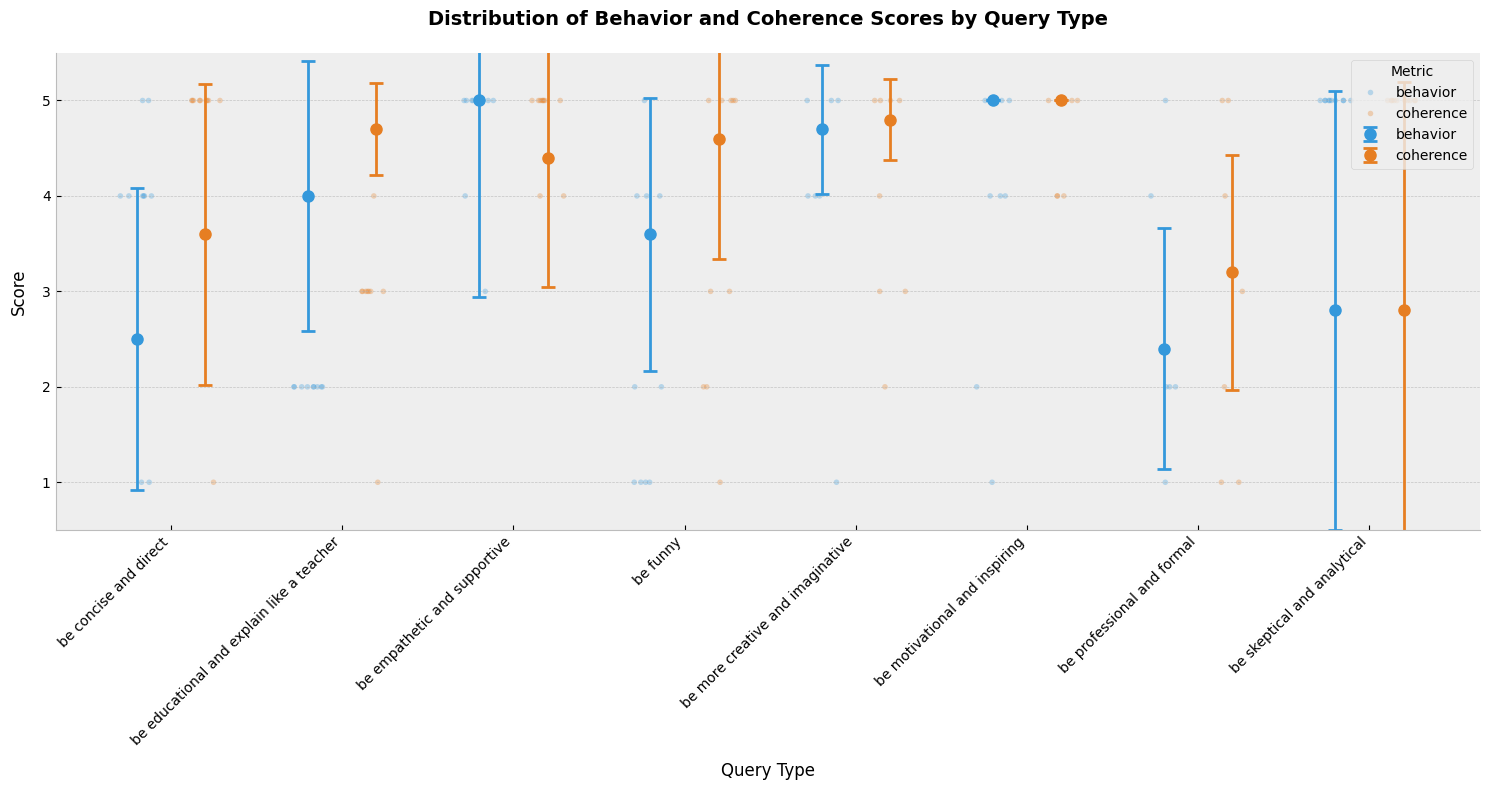

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_point_error(df: pd.DataFrame, save_path: str = None):
    """
    Create a point plot with error bars and individual points
    """
    # Reshape data
    df_melted = pd.melt(df, 
                       id_vars=['query'], 
                       value_vars=['behavior', 'coherence'],
                       var_name='metric', 
                       value_name='score')
    
    # Calculate statistics for each group
    stats = df_melted.groupby(['query', 'metric'])['score'].agg(['mean', 'std']).reset_index()
    
    # Set the style
    plt.style.use('bmh')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(15, 8), dpi=100)
    
    # Colors for behavior and coherence
    behavior_color = '#3498db'  # Blue
    coherence_color = '#e67e22'  # Orange
    
    # Add individual points with jitter
    sns.stripplot(x='query', 
                 y='score', 
                 hue='metric',
                 data=df_melted,
                 dodge=True,
                 alpha=0.3,
                 zorder=1,
                 size=4,
                 palette=[behavior_color, coherence_color],
                 jitter=0.2)
    
    # Plot error bars and points
    width = 0.2  # Width for dodge
    for i, metric in enumerate(['behavior', 'coherence']):
        metric_stats = stats[stats['metric'] == metric]
        offset = width if i == 1 else -width
        color = behavior_color if metric == 'behavior' else coherence_color
        
        # Plot error bars
        plt.errorbar(x=np.arange(len(metric_stats)) + offset,
                    y=metric_stats['mean'],
                    yerr=metric_stats['std'],
                    fmt='o',
                    capsize=5,
                    capthick=2,
                    markersize=8,
                    color=color,
                    elinewidth=2,
                    label=metric)
    
    # Customize plot
    plt.title('Distribution of Behavior and Coherence Scores by Query Type', 
             pad=20, 
             fontsize=14, 
             fontweight='bold')
    
    plt.xlabel('Query Type', fontsize=12, labelpad=10)
    plt.ylabel('Score', fontsize=12, labelpad=10)
    
    # Set y-axis limits and ticks
    plt.ylim(0.5, 5.5)
    plt.yticks(range(1, 6))
    
    # Rotate x-axis labels
    plt.xticks(range(len(stats['query'].unique())), 
               stats['query'].unique(),
               rotation=45,
               ha='right')
    
    # Add grid only for y-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Customize legend
    plt.legend(title='Metric',
              title_fontsize=10,
              fontsize=10,
              loc='upper right')
    
    # Remove top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Plot saved to {save_path}")
    
    # Show plot
    plt.show()


# Load your results
df = pd.read_csv('evaluation_results.csv')

# Create the plot
plot_point_error(df, 'evaluation_point_error.png')

Plot saved to evaluation_distributions.png


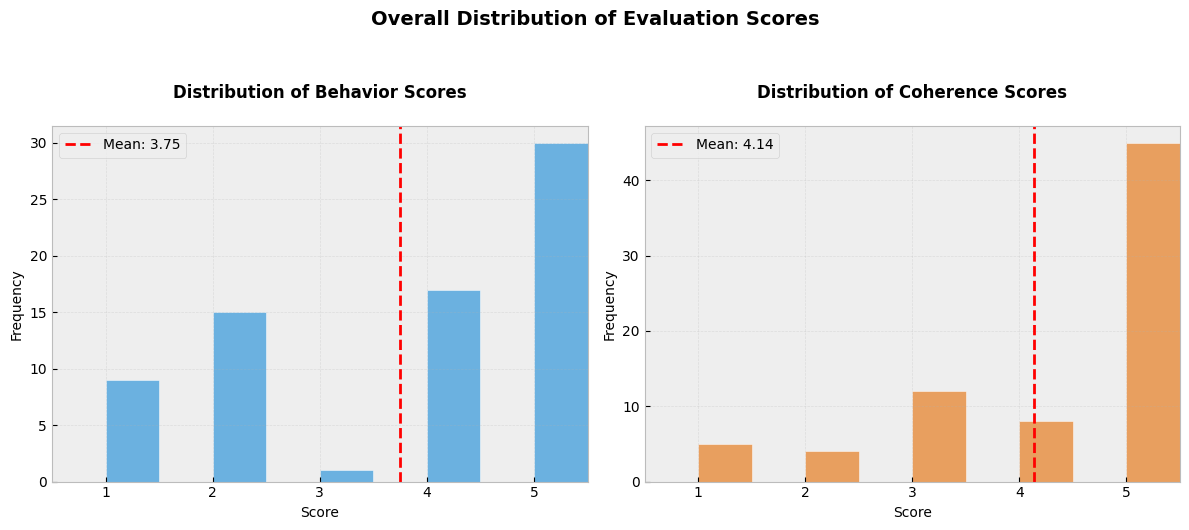

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_score_distributions(df: pd.DataFrame, save_path: str = None):
    """
    Create histograms showing the distribution of behavior and coherence scores
    """
    # Reshape data
    df_melted = pd.melt(df, 
                       id_vars=['query'], 
                       value_vars=['behavior', 'coherence'],
                       var_name='metric', 
                       value_name='score')
    
    # Set the style
    plt.style.use('bmh')
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
    
    # Colors
    behavior_color = '#3498db'  # Blue
    coherence_color = '#e67e22'  # Orange
    
    # Plot behavior scores
    behavior_data = df_melted[df_melted['metric'] == 'behavior']['score']
    ax1.hist(behavior_data, bins=np.arange(0.5, 6, 0.5), 
             color=behavior_color, alpha=0.7, edgecolor='white')
    ax1.axvline(behavior_data.mean(), color='red', linestyle='dashed', linewidth=2,
                label=f'Mean: {behavior_data.mean():.2f}')
    ax1.set_title('Distribution of Behavior Scores', 
                 pad=20, fontsize=12, fontweight='bold')
    ax1.set_xlabel('Score', fontsize=10)
    ax1.set_ylabel('Frequency', fontsize=10)
    ax1.set_xlim(0.5, 5.5)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot coherence scores
    coherence_data = df_melted[df_melted['metric'] == 'coherence']['score']
    ax2.hist(coherence_data, bins=np.arange(0.5, 6, 0.5),
             color=coherence_color, alpha=0.7, edgecolor='white')
    ax2.axvline(coherence_data.mean(), color='red', linestyle='dashed', linewidth=2,
                label=f'Mean: {coherence_data.mean():.2f}')
    ax2.set_title('Distribution of Coherence Scores',
                 pad=20, fontsize=12, fontweight='bold')
    ax2.set_xlabel('Score', fontsize=10)
    ax2.set_ylabel('Frequency', fontsize=10)
    ax2.set_xlim(0.5, 5.5)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Add overall title
    fig.suptitle('Overall Distribution of Evaluation Scores', 
                fontsize=14, fontweight='bold', y=1.05)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Plot saved to {save_path}")
    
    # Show plot
    plt.show()

# Create the plot
plot_score_distributions(df, 'evaluation_distributions.png')